### Solving a BVP with FEniCSx: 

1. Identify the computational domain (sigma) the PDE, and its corresponding boundary conditions and source terms (f).

2. Reformulate the PDE as a finite element variational problem.

3. Write a Python program defining the computational domain, the boundary conditions, the variational problem, and the source terms, using FEniCSx.

4. Run the Python program to solve the boundary-value problem. 

### Diving into the poisson problem:


1. Method of manufactured solutions: make specific choices of $\Omega, u_D$ and $f$.

2. choose

$$
\begin{align}
 u_e(x,y)=1+x^2+2y^2
 \end{align}
$$

3. Inserting $u_e$ in the original boundary problem, we find that

$$
\begin{align}
    f(x,y)= -6,\qquad u_D(x,y)=u_e(x,y)=1+x^2+2y^2,
\end{align}
$$

4. regardless of the shape of the domain as long as we prescribe
$u_e$ on the boundary.

5. For simplicity, we choose the domain to be a unit square $\Omega=[0,1]\times [0,1]$


Construct a problem with a known analytical solution, so that we can check that the computed solution is correct.



https://jsdokken.com/dolfinx-tutorial/chapter1/fundamentals.html


Hans Petter Langtangen and Anders Logg. Solving PDEs in Python: The FEniCS Tutorial I. Springer International Publishing, Cham, 2016. ISBN 978-3-319-52462-7. doi:10.1007/978-3-319-52462-7.

Hans Petter Langtangen and Kent-Andre Mardal. Introduction to Numerical Methods for Variational Problems. Springer International Publishing, Cham, 2019. ISBN 978-3-030-23788-2. doi:10.1007/978-3-030-23788-2_1.


##### environment location: /home/anushkasingh/miniconda3/envs/fenicsx-env
##### Use python 3.11.14 for compatibility with pyvista

### Mesh creation

In [ ]:
from mpi4py import MPI # message passing interface for parallel computing
from dolfinx import mesh
import numpy

# Create a mesh for the unit square 
# [0,1]×[0,1] 
# The arguments:
#   MPI.COMM_WORLD — communicator (how mesh data is distributed across processes).
#   8, 8 — number of elements in the x and y directions (so total elements = 8×8 = 64 cells).
#   mesh.CellType.quadrilateral — use quadrilateral cells (each cell is a 4-node square-like element).
domain = mesh.create_unit_square(MPI.COMM_WORLD, 8, 8, mesh.CellType.quadrilateral)

### Function Space

In [ ]:
from dolfinx import fem

# Create a finite element function space V on the mesh domain.
# element family: Lagrange (continuous piecewise-polynomial basis functions),
# degree 1 — linear basis functions on each cell.
V = fem.functionspace(domain, ("Lagrange", 1))

### Dirichlet Boundary Data (Interpolation)

In [ ]:
# Function object living in the finite-element space V. 
# This will store nodal values (degrees of freedom) of some function.
uD = fem.Function(V)
# Interpolates the given Python lambda expression into the finite-element function uD.
uD.interpolate(lambda x: 1 + x[0] ** 2 + 2 * x[1] ** 2)

### Locate boundary facets and boundary DOFs (to set Dirichlet BCs)

In [ ]:
# topological dimension of mesh (for a 2D mesh, tdim = 2).
tdim = domain.topology.dim

# is the dimension of facets (faces). In 2D, facets are 1D edges, so fdim = 1.
fdim = tdim - 1

# Constructs internal connectivity from facets (entities of dimension fdim) to cells (dimension tdim). 
# The code needs this to find which facets are on the exterior boundary.
domain.topology.create_connectivity(fdim, tdim)

# Returns a list/array of facet indices that are on the exterior boundary of the mesh.
# i.e. domain boundary
boundary_facets = mesh.exterior_facet_indices(domain.topology)

In [ ]:
# find the degrees of freedom (DOF indices) associated to those boundary facets.
boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)

# Creates a Dirichlet boundary condition object. It pairs the function uD (values to impose) to the boundary_dofs. 
# When applying this BC, the solver will enforce uh=uD at those DOFs.
bc = fem.dirichletbc(uD, boundary_dofs)

### Trial and test functions

In [ ]:
import ufl # (Unified Form Language) - to define variational forms in finite element methods

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

we want $a(u_h, v) = L(v)$ for all v in $ V_{hat} $
where $a(.,.)$ is the bilinear form and $L(.)$ is the linear form.

### Source term (constant)

In [ ]:
from dolfinx import default_scalar_type

# defines the right-hand side function f as the constant −6 across the domain. Wrapping it as a Constant is efficient and allows later changing f.value = new_value without rebuilding the variational form.
f = fem.Constant(domain, default_scalar_type(-6))

### Variational form (bilinear and linear forms)

In [ ]:
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx #rhs of variational form
L = f * v * ufl.dx # lhs of variational form

In [ ]:
from dolfinx.fem.petsc import LinearProblem

problem = LinearProblem(
    a, # bilinear form
    L, # linear form
    bcs=[bc], # list of Dirichlet boundary conditions, to be enforced during assembly/solve,
    petsc_options={"ksp_type": "preonly", "pc_type": "lu"}, #instruct PETSc to use a direct LU factorization (preonly KSP with LU preconditioner). Direct LU means the assembled matrix A is factorized and the system solved exactly (up to numerical round-off).
    petsc_options_prefix="Poisson", 
)
uh = problem.solve() #finite-element solution uh, which is returned as a Function in space V containing the degrees of freedom for the solution uh

In [ ]:
# degree-2 Lagrange space — this space can represent the exact quadratic polynomial ue exactly.
V2 = fem.functionspace(domain, ("Lagrange", 2))

# exact solution
uex = fem.Function(V2, name="u_exact")
uex.interpolate(lambda x: 1 + x[0] ** 2 + 2 * x[1] ** 2)

In [11]:
L2_error = fem.form(ufl.inner(uh - uex, uh - uex) * ufl.dx)
error_local = fem.assemble_scalar(L2_error)
error_L2 = numpy.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))

In [12]:
error_max = numpy.max(numpy.abs(uD.x.array - uh.x.array))
if domain.comm.rank == 0:  # Only print the error on one process
    print(f"Error_L2 : {error_L2:.2e}")
    print(f"Error_max : {error_max:.2e}")

Error_L2 : 8.24e-03
Error_max : 3.55e-15


### Visualization

In [ ]:
import pyvista
print(pyvista.global_theme.jupyter_backend)

trame


In [14]:
from dolfinx import plot
import pyvista

domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

/home/anushkasingh/miniconda3/envs/fenicsx-env/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


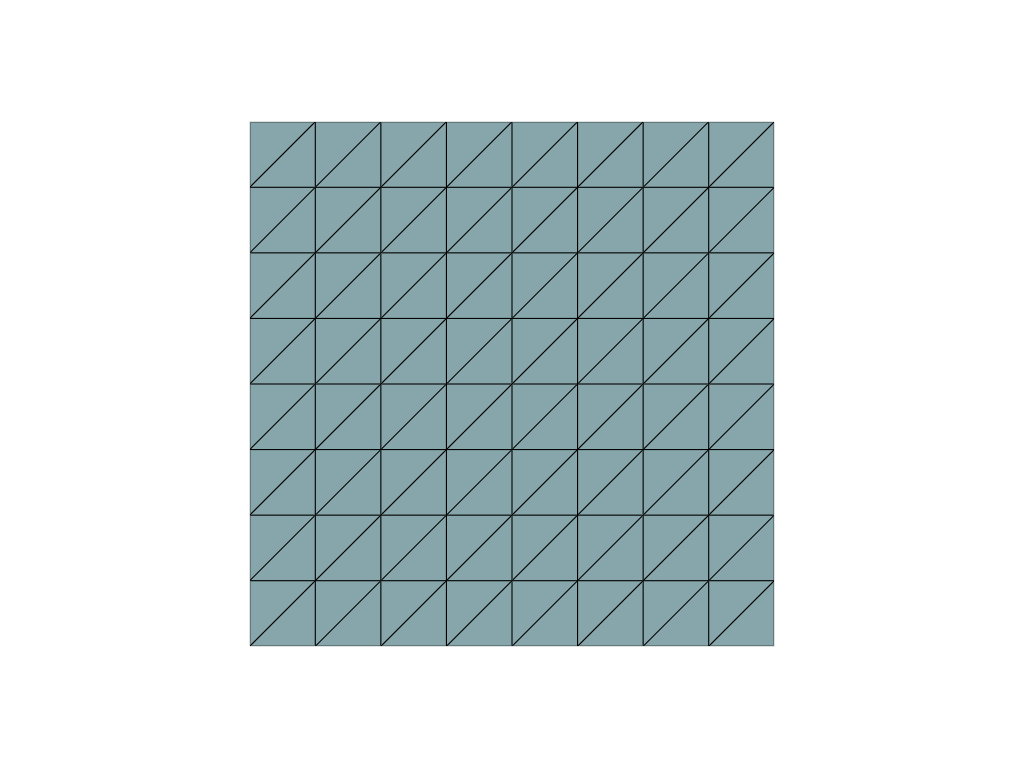

In [16]:
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

In [17]:
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)

/home/anushkasingh/miniconda3/envs/fenicsx-env/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


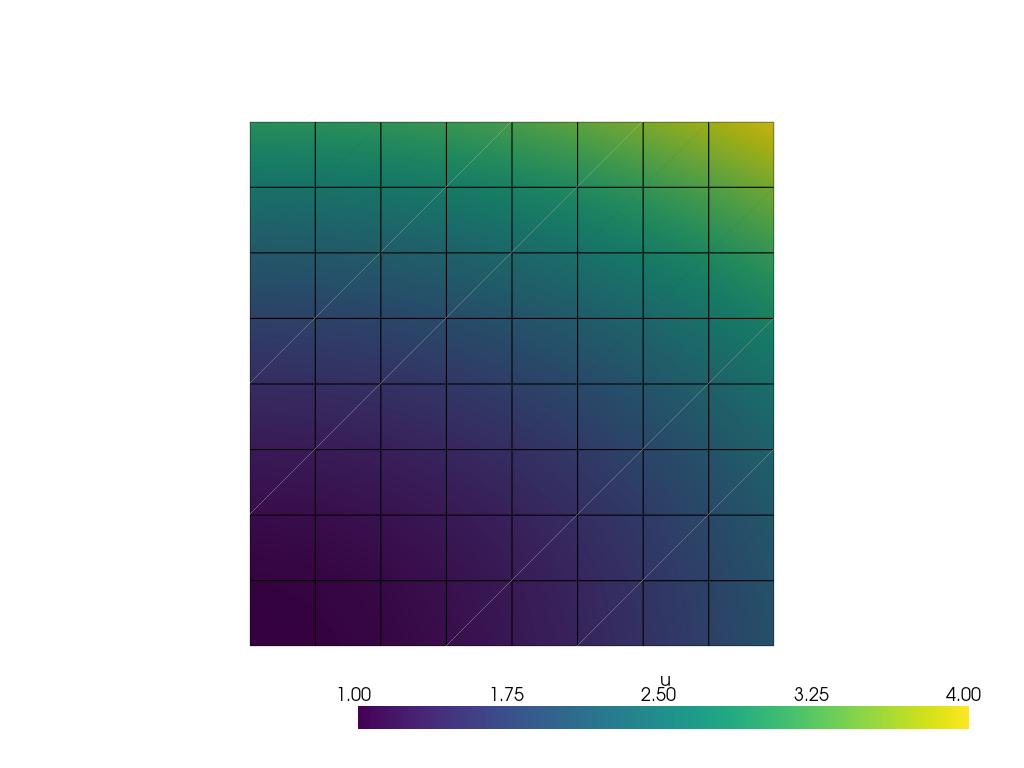

In [18]:
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

/home/anushkasingh/miniconda3/envs/fenicsx-env/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


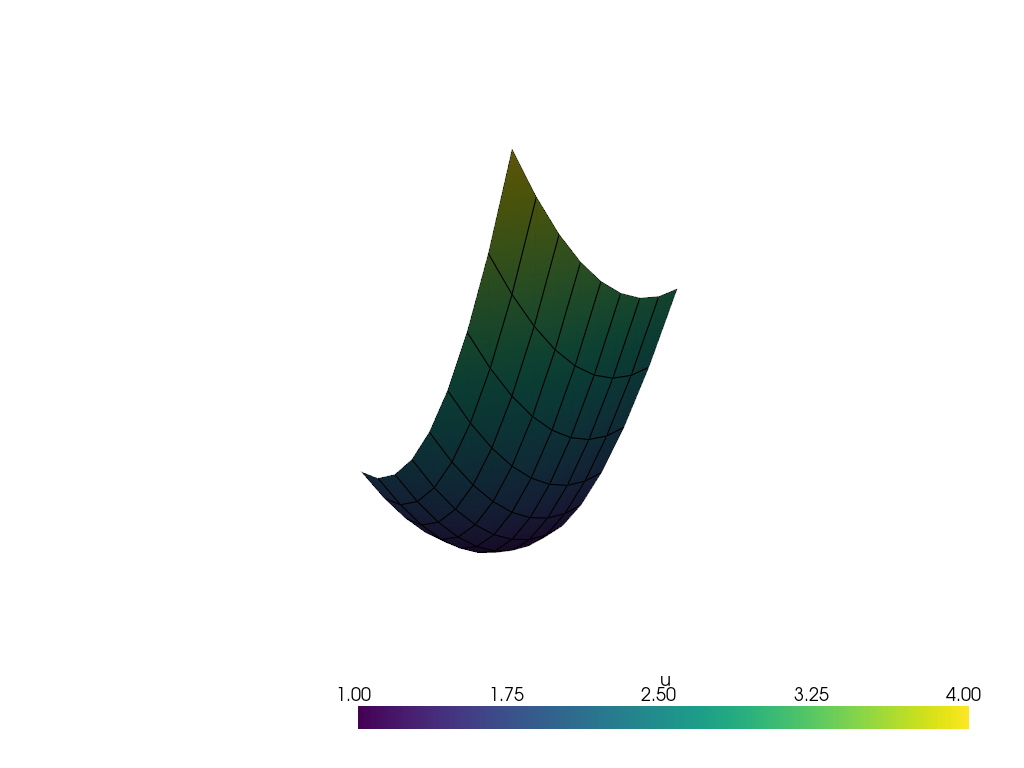

In [19]:
warped = u_grid.warp_by_scalar()
plotter2 = pyvista.Plotter()
plotter2.add_mesh(warped, show_edges=True, show_scalar_bar=True)
if not pyvista.OFF_SCREEN:
    plotter2.show()

In [20]:
from dolfinx import io
from pathlib import Path

results_folder = Path("results")
results_folder.mkdir(exist_ok=True, parents=True)
filename = results_folder / "fundamentals"
with io.VTXWriter(domain.comm, filename.with_suffix(".bp"), [uh]) as vtx:
    vtx.write(0.0)
with io.XDMFFile(domain.comm, filename.with_suffix(".xdmf"), "w") as xdmf:
    xdmf.write_mesh(domain)
    xdmf.write_function(uh)

#### Debugging:

In [21]:
# test 
from dolfinx import mesh, plot
from mpi4py import MPI
import pyvista as pv
import numpy as np

print("1. Testing PyVista basic functionality...")
print(f"PyVista version: {pv.__version__}")

# Test basic PyVista
pl = pv.Plotter()
pl.add_mesh(pv.Sphere())
pl.close()
print("✓ Basic PyVista working")

print("2. Testing FEniCSx mesh creation...")
domain = mesh.create_unit_square(MPI.COMM_WORLD, 8, 8)
print(f"✓ Mesh created with {domain.topology.index_map(2).size_global} cells")

print("3. Testing VTK mesh extraction...")
domain.topology.create_connectivity(2, 2)
topology, cell_types, geometry = plot.vtk_mesh(domain, 2)
print("✓ VTK mesh extraction successful")

print("4. Testing PyVista grid creation...")
grid = pv.UnstructuredGrid(topology, cell_types, geometry)
print("✓ PyVista grid creation successful")

print("🎉 ALL VISUALIZATION TESTS PASSED!")

1. Testing PyVista basic functionality...
PyVista version: 0.46.3
✓ Basic PyVista working
2. Testing FEniCSx mesh creation...
✓ Mesh created with 128 cells
3. Testing VTK mesh extraction...
✓ VTK mesh extraction successful
4. Testing PyVista grid creation...
✓ PyVista grid creation successful
🎉 ALL VISUALIZATION TESTS PASSED!
